In [1]:
USE_MULTIPROCESSING = True

In [2]:
import os, shutil
import sys

if os.path.isdir("__pycache__"):
    shutil.rmtree("__pycache__")

from modules.balance_dataset import input_output
from modules.evaluation import fitness
from modules.utils import results_folder
from modules import visualize

from modules import operator_set
import operator

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp
from deap import tools

from modules.statistics import runtime_metrics
import time
import numpy as np
import math
import random

if USE_MULTIPROCESSING:
    import multiprocessing as mp
    from multiprocessing import Pool
    import psutil

In [3]:
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '|'):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end = '\r')
    # Print New Line on Complete
    if iteration == total: 
        print()

In [4]:
DATASET_FOLDER = 'modules/data/500ms'
FILE_LIST = ['wav_ex1_spindles.csv','wav_ex2_spindles.csv','wav_ex3_spindles.csv','wav_ex4_spindles.csv','wav_ex5_spindles.csv','wav_ex6_spindles.csv','wav_ex7_spindles.csv','wav_ex8_spindles.csv']

Importing data

In [5]:
data = input_output.read_dataset_list(DATASET_FOLDER, FILE_LIST)
X_train, y_train, X_test, y_test = input_output.balance_dataset(data, data_columns = list(range(0,75)), label_column = 75, test_size = .2)

X_train = np.array(X_train)
X_test  = np.array(X_test)

# One hot vector
y_train = np.array([[x, int(not x)] for x in y_train])
y_test  = np.array([[x, int(not x)] for x in y_test])

Select the evaluation metric

In [6]:
opt_vars = ['auc']
eval_func = fitness.eval_function(opt_vars)
# Result: eval_func -> auc = lambda(y_true, y_pred)

# eval_func = fitness.eval_function(['auc', 'acc'])
## Result: eval_func -> auc, acc = lambda(y_true, y_pred)

In [7]:
# Number of inputs
n_att = 75

Select the classifier

In [8]:
'''
    options:
        nb: Naive Bayes; params: None
        dt: Decision Tree; params: None
        mlp: Multilayer Perceptron; params: [first hidden layer size,activation function]
        knn: K Nearest Neighbors; params: [K,-1]
        svm: Support Vector Machine; params: [-1,kernel]
        kmeans: K-means Clustering (Using each cluster as a class of the problem); params: [number of clusters, -1]
        external: Default = False. You can use any classifier, but the following methods (like scikit-learn):
            fit(X, y)
            predict(X)
            predict_proba(X)

    Example 1:
    from sklearn.ensemble import RandomForestClassifier
    classifier = 'rf'
    external = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
    
    Example 2:
    classifier = 'nb'
    external = False
    
    Example 3:
    classifier = 'svm'
    clf_param = [[], ['rbf']]
    external = False
'''
classifier = 'nb'
external = False
clf_param = [[],[]] 


GP operator set

In [9]:
pset = gp.PrimitiveSet("MAIN", n_att)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(operator_set.plog, 1)
pset.addPrimitive(operator_set.psqrt, 1)
pset.addPrimitive(operator_set.pdiv, 2)
pset.addPrimitive(operator_set.F, 1)
# pset.addPrimitive(math.sin, 1)
# pset.addPrimitive(math.cos, 1)
# pset.addPrimitive(operator.neg, 1)

GP parameters

In [10]:
'''
    Multiparameter optimization
    opt_vars -> evaluation metrics
    wts_vars -> tuple with each metric weight
    
    Example: Optimizing False positives and True positives
    opt_vars = [FP, TP]
    wts_vars = tuple([-1, 2])
    
    It means that we want to reduce False positives and maximize True positives. And it is more 
    important to have True positives, because we have set its weight higher.
'''
wts_vars = tuple([1])

creator.create("FitnessMulti", base.Fitness, weights = wts_vars)
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMulti)

toolbox = base.Toolbox()
# Individual and population
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=3)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

# Evaluation method
toolbox.register("evaluate", fitness.eval_tree, clf = classifier, X_train = X_train, y_train = y_train, X_test = X_test, y_true = y_test, pset = pset, opt_vars = opt_vars, eval_func = eval_func, param = clf_param, external = external)

# Initialization
# toolbox.register("expr_init", gp.genFull, min_=4, max_=7)
# toolbox.register("expr_init", gp.genGrow, min_=4, max_=7)
toolbox.register("expr_init", gp.genHalfAndHalf, min_=4, max_=7)

# Selection
toolbox.register("select", tools.selTournament, tournsize=3)
# toolbox.register("select", tools.selRoulette)
# toolbox.register("select", tools.selRandom)

# Crossover
toolbox.register("mate", gp.cxOnePoint)
# toolbox.register("mate", gp.cxTwoPoint)
# toolbox.register("mate", gp.cxcxOnePointLeafBiased, termpb =.1)

# Mutation
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_init, pset=pset)
# toolbox.register("mutate", gp.mutNodeReplacement, pset=pset)
# toolbox.register("mutate", gp.mutInsert, pset=pset)
# toolbox.register("mutate", gp.mutShrink)toolbox.register("mutate", gp.mutEphemeral, mode = 'all')

# Bloat Control
TAM_MAX = 10
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value = TAM_MAX))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value = TAM_MAX))

Statistics

In [11]:
# random.seed(1)
start = time.time()
mstats = runtime_metrics.init_stats()

GP start: Population 0

In [12]:
# Population size
NPOP = 100

# Execution number (identifier)
NEXEC = 1

# Number of generations
NGEN = 100

# Crossover probability
CXPB = .85

# Mutation probability
MUTPB = .15
pop = toolbox.population(NPOP)

# Much faster!
if USE_MULTIPROCESSING:
    def ff(ind):
        fit = fitness.eval_tree(ind, clf = classifier, X_train = X_train, y_train = y_train, X_test = X_test, y_true = y_test, pset = pset, opt_vars = opt_vars, eval_func = eval_func, param = clf_param, external = external)
        if (math.isnan(fit[0])):
            ind.fitness.values = 0,
        else:
            ind.fitness.values = fit
        return ind

    def fmate(children):
        if random.random() < CXPB:
            children = toolbox.mate(children[0], children[1])
            del children[0].fitness.values
            del children[1].fitness.values
        return children[0], children[1]
    
    def fmutate(mutant):
        if random.random() < MUTPB:
            mutant = toolbox.mutate(mutant)[0]
            del mutant.fitness.values
        return mutant
    
    # t1 = time.time()
    p = Pool(psutil.cpu_count()*2)
    pop = p.map(ff, pop)
    # t2 = time.time()
      
else:
    # t3 = time.time()
    fitnesses = list(map(toolbox.evaluate, pop))
    
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit
        if (math.isnan(fit[0])):
            ind.fitness.values = 0,
        else:
            ind.fitness.values = fit
    # t4 = time.time()

/usr/local/lib/python3.5/dist-packages/sklearn/naive_bayes.py:432: RuntimeWarning: divide by zero encountered in log
  n_ij = - 0.5 * np.sum(np.log(2. * np.pi * self.sigma_[i, :]))
/usr/local/lib/python3.5/dist-packages/sklearn/naive_bayes.py:434: RuntimeWarning: invalid value encountered in true_divide
  (self.sigma_[i, :]), 1)


More statistics

In [13]:
log = tools.Logbook()
hof = tools.selBest(pop, 1)

GP start

In [14]:
toolbar_width = 50
if NGEN < 50:
    toolbar_width = NGEN

# Verbosity level
verb = 1
if verb >= 1:
    print(">> (Exec " + str(NEXEC) + ") GP + " + classifier + " - Feature Selection and Construction")
    print(">> NGEN = " + str(NGEN) + " | NPOP = " + str(NPOP) + " | MAX_DEPTH = " + str(TAM_MAX) + " | PARAM = " + str(clf_param))
    print(">> Optimizing: " + str(opt_vars))
    print(">> Weights:    " + str(wts_vars))
    # if verb == 1:
    #    sys.stdout.write("[%s]" % (" " * toolbar_width))
    #    sys.stdout.flush()
    #    sys.stdout.write("\b" * (toolbar_width+1))

# Results folder
path = 'result_GP_' + str(NEXEC) + '/'
results_folder.verify_create_dir(path)

filename = 'GP_'+ classifier + '_' + 'NEXEC'
balance = 1

if verb == 1:
    printProgressBar(0, NGEN, prefix = '>> Progress:', suffix = 'Complete', length = 50)

for g in range(NGEN):
    geninit = time.time()
    
    if verb == 1:
        printProgressBar(g + 1, NGEN, prefix = '>> Progress:', suffix = 'Complete', length = 50)

    pop = toolbox.select(pop, NPOP)

    if USE_MULTIPROCESSING:
        offspring = list(map(toolbox.clone, pop))
        offspring = p.map(fmate, list(zip(offspring[::2], offspring[1::2])))
        offspring = [xx for sub in offspring for xx in sub]
        offspring = p.map(fmutate, offspring)
        offspring = p.map(ff, offspring)
    else:
        offspring = algorithms.varAnd(pop, toolbox, CXPB, MUTPB)
        fitnesses = list(map(toolbox.evaluate, offspring))

        for ind, fit in zip(offspring, fitnesses):
            ind.fitness.values = fit
            if (math.isnan(fit[0])):
                ind.fitness.values = 0,
            else:
                ind.fitness.values = fit

    hof = tools.selBest(pop, 1)

    pop[:] = offspring + hof
    log.record(gen = g, time = time.time() - geninit,**mstats.compile(pop))

    if verb == 1:
        if(g%int(NGEN/toolbar_width) == 0):
            sys.stdout.write("-")
            sys.stdout.flush()
    elif verb == 2:
        print(log.stream)

end = time.time()

total_time = end - start

if verb >= 1:
    if total_time < 60:
        print("\n>> End (" + str(round(total_time)) + " seconds)\n")
    elif total_time < 3600:
        print("\n>> End (" + str(round(total_time/60)) + " minutes)\n")
    else:
        print("\n>> End (" + str(math.floor(total_time/3600)) + " hours and " + str(round(abs(math.floor(total_time/3600)-total_time/3600)*60)) + " minutes)\n")

logfile = open(path + "log/LOG_" + filename + "_" + str(NEXEC) + ".csv", 'w')
logfile.write(str(log))
logfile.close()

prf, acc, cfm, AUC = fitness.performance(hof[0], classifier, X_train, y_train, X_test, y_test, pset, clf_param, external)

info_file_name = os.path.join(path,"infoGP.csv")
infoGP = open(info_file_name, 'a')
if os.stat(info_file_name).st_size == 0:
    infoGP.write("balance,DEEP MAX,classifier,P1,P2,#Exec,PPV_S,PPV_NS,TPR_S,TPR_NS,F1_S,F1_NS,SUP_S,SUP_NS,TN,FP,FN,TP,Acc,AUC,Deep,Training Time\n")

infoGP.write(str(balance) + ',' + str(TAM_MAX) + ',' + classifier + ',' + str(clf_param[0]) + ',' + str(clf_param[1]) + ',' +  str(NEXEC) + ',' + str(prf[0][0]) + ',' 
        + str(prf[0][1]) + ',' + str(prf[1][0]) + ',' + str(prf[1][1]) + ',' + str(prf[2][0]) + ',' 
        + str(prf[2][1]) + ',' + str(prf[3][0]) + ',' + str(prf[3][1]) + ',' 
        + str(cfm[0]) + ',' + str(cfm[1]) + ',' + str(cfm[2]) + ',' + str(cfm[3]) + ',' 
        + str(acc) + ',' + str(AUC) + ',' + str(hof[0].height) + ',' + str(total_time) + '\n')

infoGP.close()

tree = gp.PrimitiveTree(hof[0])
expFILE = open(path + "best_expr/EXPR_" + filename + "_" +  str(NEXEC) + ".txt", 'w')
expFILE.write(str(tree))
expFILE.close()

>> (Exec 1) GP + nb - Feature Selection and Construction
>> NGEN = 100 | NPOP = 100 | MAX_DEPTH = 10 | PARAM = [[], []]
>> Optimizing: ['auc']
>> Weights:    (1,)
>> Progress: |||||||||||||||||||||||||||||||||||||||||||||||||||| 100.0% Complete

>> End (10 minutes)



Visualize the best feature set created

In [23]:
list(set(visualize.get_equations_simplified(hof[0])))

[-ARG11 - ARG16 + ARG58,
 ARG46,
 ARG39 - ARG5,
 -ARG11 + ARG16 + ARG39 - ARG5,
 ARG12,
 log(ARG38),
 log(ARG74),
 sqrt(log(ARG12)),
 ARG11,
 ARG39,
 sqrt(ARG53)]

In [24]:
prf, acc, cfm, AUC = fitness.performance(hof[0], classifier, X_train, y_train, X_test, y_test, pset, clf_param, external)
print('Precision: ', round(prf[0][0], 4))
print('Recall   : ', round(prf[1][0], 4))
print('F1-Score : ', round(prf[2][0], 4))
print('Accuracy : ', round(acc, 4))
print('AUC      : ', round(AUC, 4))

Precision:  0.7717
Recall   :  0.8673
F1-Score :  0.8167
Accuracy :  0.8053
AUC      :  0.8495


In [17]:
fitness.performance(hof[0], 'nb', X_train, y_train, X_test, y_test, pset, external = False)

((array([0.77165354, 0.84848485]),
  array([0.86725664, 0.74336283]),
  array([0.81666667, 0.79245283]),
  array([226, 226])),
 0.8053097345132744,
 array([168,  58,  30, 196]),
 0.8494987861226407)

In [18]:
fitness.performance(hof[0], 'dt', X_train, y_train, X_test, y_test, pset)

((array([0.71300448, 0.70742358]),
  array([0.70353982, 0.71681416]),
  array([0.70824053, 0.71208791]),
  array([226, 226])),
 0.7101769911504425,
 array([162,  64,  67, 159]),
 0.7101769911504425)

In [19]:
fitness.performance(hof[0], 'knn', X_train, y_train, X_test, y_test, pset, [5,''])

((array([0.72477064, 0.70940171]),
  array([0.69911504, 0.73451327]),
  array([0.71171171, 0.72173913]),
  array([226, 226])),
 0.7168141592920354,
 array([166,  60,  68, 158]),
 0.8009339024199232)

In [20]:
fitness.performance(hof[0], 'mlp', X_train, y_train, X_test, y_test, pset, [15,'relu'])

((array([0.76168224, 0.73529412]),
  array([0.72123894, 0.77433628]),
  array([0.74090909, 0.75431034]),
  array([226, 226])),
 0.7477876106194691,
 array([175,  51,  63, 163]),
 0.8273553136502467)

In [21]:
fitness.performance(hof[0], 'svm', X_train, y_train, X_test, y_test, pset, ['','rbf'])

((array([0.58146965, 0.68345324]),
  array([0.80530973, 0.42035398]),
  array([0.67532468, 0.52054795]),
  array([226, 226])),
 0.6128318584070797,
 array([ 95, 131,  44, 182]),
 0.7027370976583914)

Plot the GP tree

/usr/local/lib/python3.5/dist-packages/networkx-2.1-py3.5.egg/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


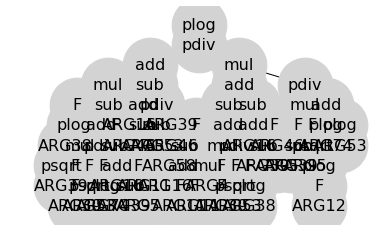

In [22]:
# If the image appears wierd, please run this instruction again
visualize.plot_tree(hof[0], path = path + "best_expr/EXPR_" + filename + "_" +  str(NEXEC) + ".pdf")